In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logit, expit
import pandas as pd

from sklearn.metrics import auc

from src.metrics import dice_coef, dice_norm_metric, soft_dice_norm_metric, rc_curve
from src.confidence import (ExpectedEntropy, ExpectedEntropy_With_If,
                            MeanMaxConfidence, MeanMaxConfidence_With_If,
                            PredChangeDSC, PredChangeDSC_With_If,
                            DSCIntegralOverThreshold, SoftDice,
                            DSCIntegralOverNoise)
from src.utils import plot_baselines, plot_rc_curve, plot_rc_curves

In [93]:
def busi_unext_val_dice(confidence_metrics: dict):
    data = np.load('data/pred/busi_unext_val.npz')
    y = data['y']
    y_hat = data['y_hat']

    any_foreground_predicted = (y_hat > .5).reshape(y_hat.shape[0],-1).any(axis=1)
    y = y[any_foreground_predicted]
    y_hat = y_hat[any_foreground_predicted]

    fig, ax = plt.subplots()

    dice_scores = np.stack([dice_coef(y_hat[i], y[i]) for i in range(len(y))])
    dice_errors = 1 - dice_scores

    confidences = {name: [confidence_metric(y_hat_i) for y_hat_i in y_hat]
                for name, confidence_metric in confidence_metrics.items()}

    ax = plot_rc_curves(confidences, dice_errors, ax)

    ax.set_title('BUSI val with U-Next')
    ax.set_ylabel('1-Dice')
    ax.set_xlabel('Coverage')

    return fig

def busi_unext_test_dice(confidence_metrics: dict):
    data = np.load('data/pred/busi_unext_test.npz')
    y = data['y']
    y_hat = data['y_hat']

    any_foreground_predicted = (y_hat > .5).reshape(y_hat.shape[0],-1).any(axis=1)
    y = y[any_foreground_predicted]
    y_hat = y_hat[any_foreground_predicted]

    fig, ax = plt.subplots()

    dice_scores = np.stack([dice_coef(y_hat[i], y[i]) for i in range(len(y))])
    dice_errors = 1 - dice_scores

    confidences = {name: [confidence_metric(y_hat_i) for y_hat_i in y_hat]
                for name, confidence_metric in confidence_metrics.items()}

    ax = plot_rc_curves(confidences, dice_errors, ax)

    ax.set_title('BUSI test with U-Next')
    ax.set_ylabel('1-Dice')
    ax.set_xlabel('Coverage')
    
    return fig

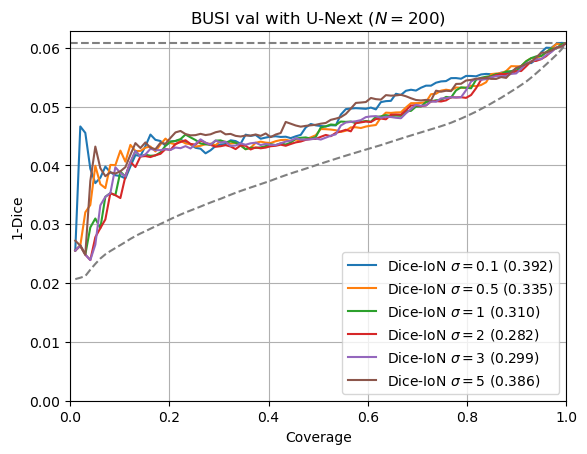

In [107]:
N = 200
confidence_metrics = {
    'Dice-IoN $\sigma=0.1$': DSCIntegralOverNoise(N, 0.1),
    'Dice-IoN $\sigma=0.5$': DSCIntegralOverNoise(N, 0.5),
    'Dice-IoN $\sigma=1$': DSCIntegralOverNoise(N, 1),
    'Dice-IoN $\sigma=2$': DSCIntegralOverNoise(N, 2),
    'Dice-IoN $\sigma=3$': DSCIntegralOverNoise(N, 3),
    'Dice-IoN $\sigma=5$': DSCIntegralOverNoise(N, 5),
}

fig = busi_unext_val_dice(confidence_metrics)

curr_title = fig.gca().get_title()
fig.gca().set_title(curr_title + f' ($N={N}$)')
fig.show()

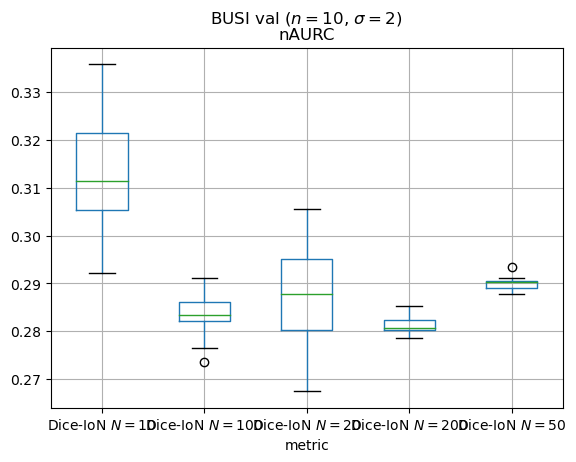

In [103]:
data = np.load('data/pred/busi_unext_val.npz')
y = data['y']
y_hat = data['y_hat']

any_foreground_predicted = (y_hat > .5).reshape(y_hat.shape[0],-1).any(axis=1)
y = y[any_foreground_predicted]
y_hat = y_hat[any_foreground_predicted]

dice_scores = np.stack([dice_coef(y_hat[i], y[i]) for i in range(len(y))])
dice_errors = 1 - dice_scores

ideal_coverage, ideal_risk, _ = rc_curve(-dice_errors, dice_errors)
ideal_aurc = auc(ideal_coverage, ideal_risk)
baseline_aurc = np.mean(dice_errors)

confidence_metrics = {
    'Dice-IoN $N=10$': DSCIntegralOverNoise(10, 2),
    'Dice-IoN $N=20$': DSCIntegralOverNoise(20, 2),
    'Dice-IoN $N=50$': DSCIntegralOverNoise(50, 2),
    'Dice-IoN $N=100$': DSCIntegralOverNoise(100, 2),
    'Dice-IoN $N=200$': DSCIntegralOverNoise(200, 2),
}

df = pd.DataFrame(columns=['metric', 'nAURC'])
for _ in range(10):
    confidences = {name: [confidence_metric(y_hat_i) for y_hat_i in y_hat]
                   for name, confidence_metric in confidence_metrics.items()}
    
    for name, confidence in confidences.items():
        coverages, risks, _ = rc_curve(confidence, dice_errors)

        aurc = auc(coverages, risks)
        naurc = (aurc - ideal_aurc) / (baseline_aurc - ideal_aurc)

        df.loc[len(df)] = {
            'metric': name,
            'nAURC': naurc,
        }
df.boxplot('nAURC', by='metric')
plt.gcf().set_size_inches(10,6)
plt.gcf().suptitle('BUSI val ($n=10$, $\sigma=2$)')
plt.show()

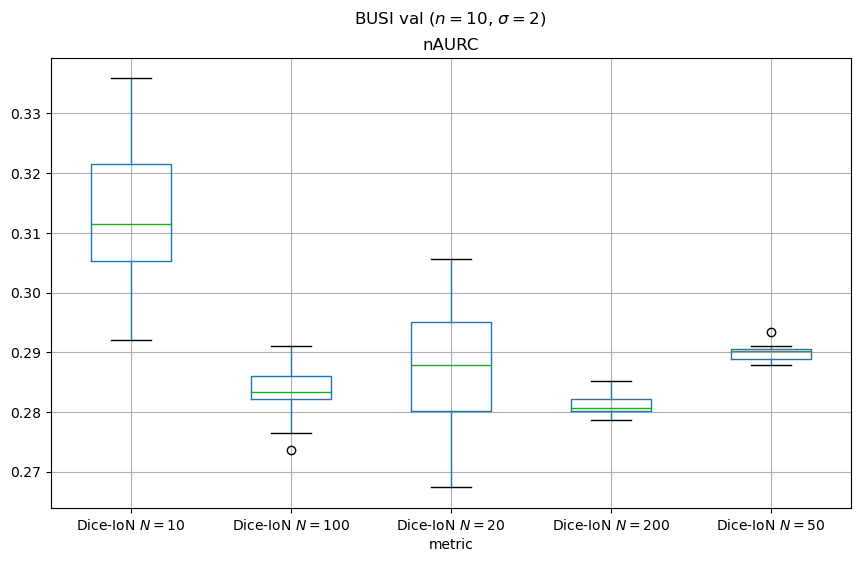

In [105]:
df.boxplot('nAURC', by='metric')
plt.gcf().set_size_inches(10,6)
plt.gcf().suptitle('BUSI val ($n=10$, $\sigma=2$)')
plt.show()